In [13]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import numpy as np
from utils.models import mGradNet_C, mGradNet_M, WSoftmax, WTanh
from utils.pdfs import MixtureOfGaussians
import matplotlib.pyplot as plt 

# set random seeds for reproducibility
np.random.seed(1234)
torch.manual_seed(1234)
if torch.cuda.is_available():
    torch.cuda.manual_seed(1234)
device = torch.device('cuda:7') if torch.cuda.is_available() else torch.device('cpu')

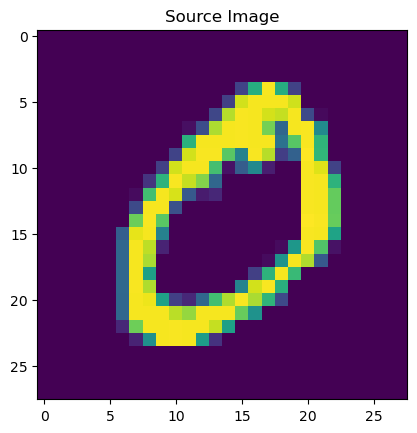

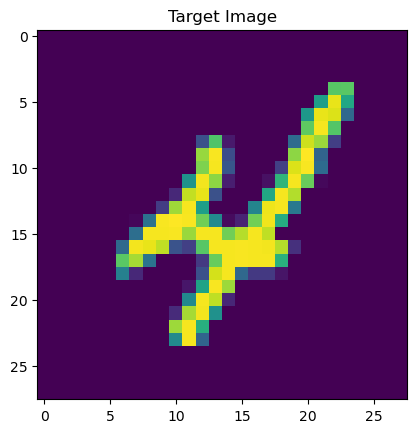

In [14]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# change to be any number from 0 to 9
source_num = 0
target_num = 4

source_img = x_train[y_train == source_num][0] 
target_img = x_train[y_train == target_num][1]

source_img = torch.from_numpy(source_img)
target_img = torch.from_numpy(target_img)

plt.figure()
plt.title('Source Image')
plt.imshow(source_img)

plt.figure()
plt.title('Target Image')
plt.imshow(target_img)


/home/shreyasc/miniconda3/envs/py311/lib/python3.11/site-packages/torch/distributions/distribution.py:55: UserWarning: <class 'pdfs.MixtureOfGaussians'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(


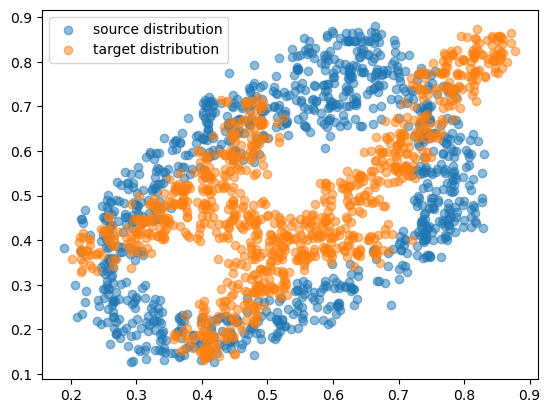

In [15]:
# convert nxn image to smooth density using KDE

def img2density(img, bandwidth=1e-4):
    n = img.shape[0]


    lin = torch.arange(n)
    grid_y, grid_x = torch.meshgrid(lin, lin, indexing='ij')  # (n, n)

    # Flip y axis so y=0 at bottom instead of top
    grid_y = (n - 1) - grid_y

    # Stack as (x, y) normalized to [0,1]
    grid = torch.stack([grid_x, grid_y], dim=-1).reshape(-1, 2).float()
    grid = grid / (n - 1)

    weights = img.reshape(-1) / img.sum()
    idx = weights > 1e-3  # Filter out very low weights
    weights = weights[idx]
    grid = grid[idx]
    covs = torch.eye(2).unsqueeze(0).repeat(grid.shape[0], 1, 1) * bandwidth
    return MixtureOfGaussians(weights=weights, means=grid, covariances=covs, device=device)

source = img2density(source_img)
target = img2density(target_img)

source_samples = source.sample(1000).cpu()
target_samples = target.sample(1000).cpu()
plt.scatter(source_samples[:,0], source_samples[:,1], label='source distribution', alpha=0.5)
plt.scatter(target_samples[:,0], target_samples[:,1], label='target distribution', alpha=0.5)
plt.legend()

In [16]:
from torch.optim import Adam, SGD, RMSprop
from torch.func import vmap, jacrev
from torch.nn.utils import clip_grad_norm_
from tqdm import trange

# Define the OT map model
otmap = mGradNet_M(num_modules=32, in_dim=2, embed_dim=128, activation=lambda: WSoftmax())


# Train the OT map
iters = 10000
init_bw = 1e-2
end_bw = 1e-4
otmap = otmap.to(device)
otmap.train()
opt = torch.optim.AdamW(otmap.parameters(), lr=1, weight_decay=1e-4)
sch = torch.optim.lr_scheduler.StepLR(opt, step_size=1000, gamma=0.5)
jacobian_fn = jacrev(otmap)
batched_jacobian_fn = vmap(jacobian_fn)
pbar = trange(iters, dynamic_ncols=True) 

for i in pbar:
    
    opt.zero_grad()

    # decay bandwidth
    source = img2density(source_img, bandwidth=init_bw * (end_bw/init_bw)**(i/iters))  
    target = img2density(target_img, bandwidth=init_bw * (end_bw/init_bw)**(i/iters))  
    samples = source.sample(1000).to(device) # sample points from the source distribution
    
    J = batched_jacobian_fn(samples)
    J = J.squeeze(1)
    _, logabsdet = torch.linalg.slogdet(J)

    out = otmap(samples)
    log_p = source.log_pdf(samples)       # source log-density
    log_q = target.log_pdf(out)           # target log-density

    loss = F.l1_loss(logabsdet, log_p - log_q) # L1 loss on logabsdet and OT map output
    loss.backward()
    clip_grad_norm_(otmap.parameters(), max_norm=10.0) # clip gradient norms for stability
    opt.step()
    sch.step()
    
    pbar.set_description(f"Loss: {loss.item():.4f}")

Loss: 0.7720: 100%|██████████| 10000/10000 [13:33<00:00, 12.30it/s]


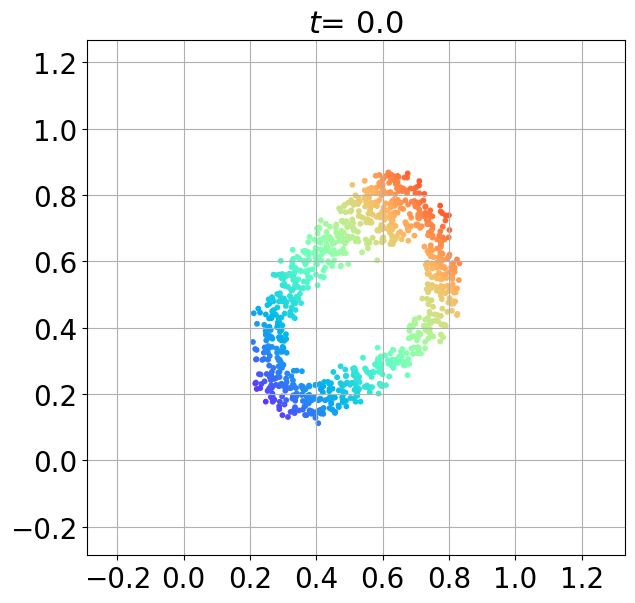

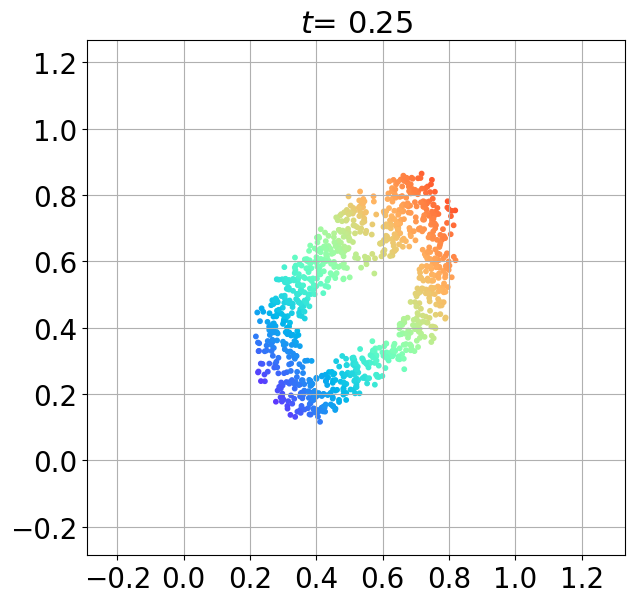

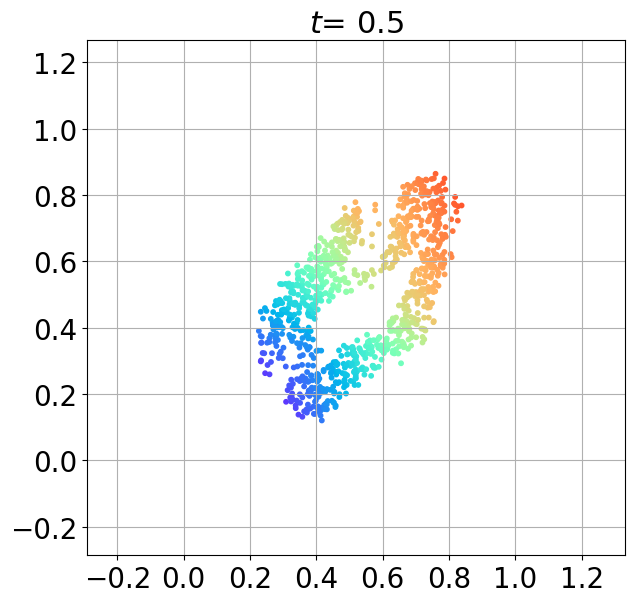

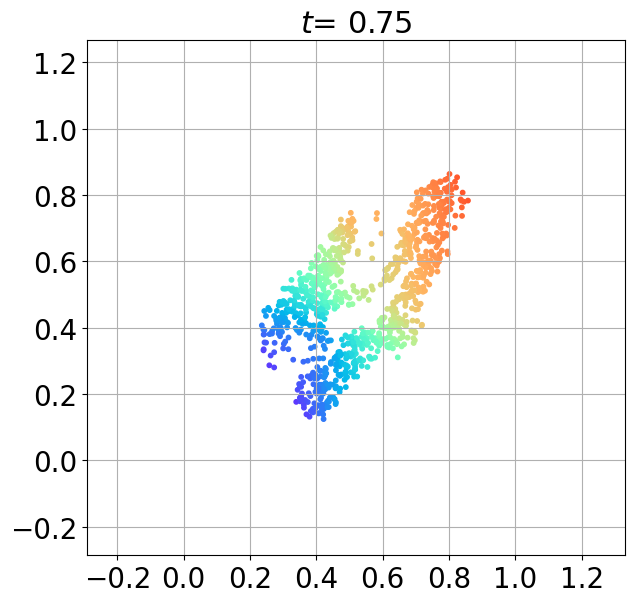

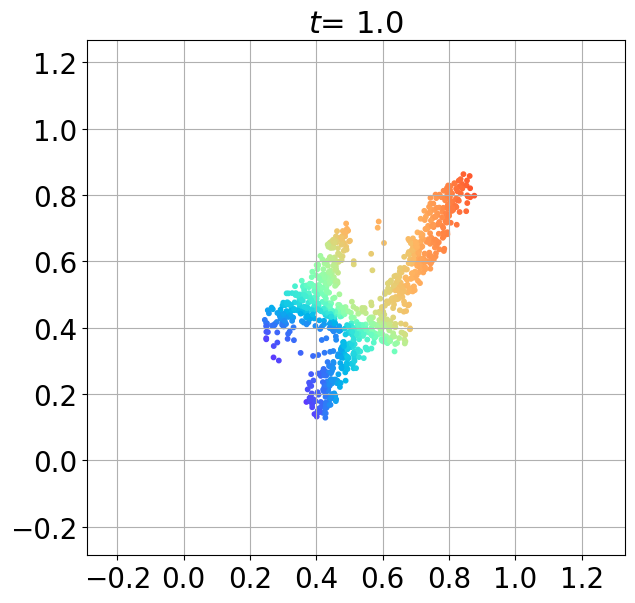

In [26]:
# Plot the learned OT map
from matplotlib.cm import rainbow
import os
otmap = otmap.to(device)
otmap.eval()
t_vals = np.linspace(0, 1, 5)

# Normalize 2D positions to [0, 1] for coloring
source = img2density(source_img, bandwidth=1e-4)
source_samples = source.sample(1000).to(device)
x_min, x_max = source_samples[:, 0].min(), source_samples[:, 0].max()
y_min, y_max = source_samples[:, 1].min(), source_samples[:, 1].max()

X_norm = torch.zeros_like(source_samples).cpu()
X_norm[:, 0] = (source_samples[:, 0] - x_min) / (x_max - x_min + 1e-8)
X_norm[:, 1] = (source_samples[:, 1] - y_min) / (y_max - y_min + 1e-8)

# Combine x and y into a single scalar for colormap mapping
color_weights = 0.5 * X_norm[:, 0] + 0.5 * X_norm[:, 1]  # weighted average
colors = rainbow(color_weights.cpu())

for t in t_vals:
    with torch.no_grad():
        interpolated = (1 - t) * source_samples.cpu() + t * otmap(source_samples).cpu().detach()
    plt.figure(figsize=(6, 6))
    plt.scatter(interpolated[:, 0], interpolated[:, 1], s=10, color=colors, label=f"t={t:.2f}")
    plt.title('$t$= ' + str(t), fontsize=22)
    plt.axis("equal")
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(x_min.cpu()-0.5, x_max.cpu()+0.5)
    plt.ylim(y_min.cpu()-0.5, y_max.cpu()+0.5)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.show()

In [27]:
import ot
from sklearn.metrics import mean_squared_error

source_samples = source.sample(1000).cpu().numpy()
target_samples = target.sample(1000).cpu().numpy()

n = source_samples.shape[0]
a = np.ones(n) / n  # uniform source weights
b = np.ones(n) / n  # uniform target weights

def barycentric_projection(source, target, gamma):
    """
    source: (n, d) source samples
    target: (n, d) target samples
    gamma: (n, n) optimal transport plan (from ot.emd)
    Returns: (n, d) barycentric projection T(x)
    """
    gamma_sum = np.sum(gamma, axis=1, keepdims=True)  # shape (n, 1)
    # Avoid divide-by-zero
    gamma_sum[gamma_sum == 0] = 1e-8
    T = gamma @ target / gamma_sum
    return T

M = ot.dist(source_samples, target_samples, metric='euclidean') ** 2  # shape (n, n)
G = ot.emd(a, b, M) 
T_ot = barycentric_projection(source_samples, target_samples, G)
with torch.no_grad():
    otmap = otmap.to('cpu')
    T_pred = otmap(torch.from_numpy(source_samples)).numpy()

mse = mean_squared_error(T_pred, T_ot)
print(f"MSE between learned Monge map and discrete OT barycentric map: {mse:.5f}")

MSE between learned Monge map and discrete OT barycentric map: 0.00052


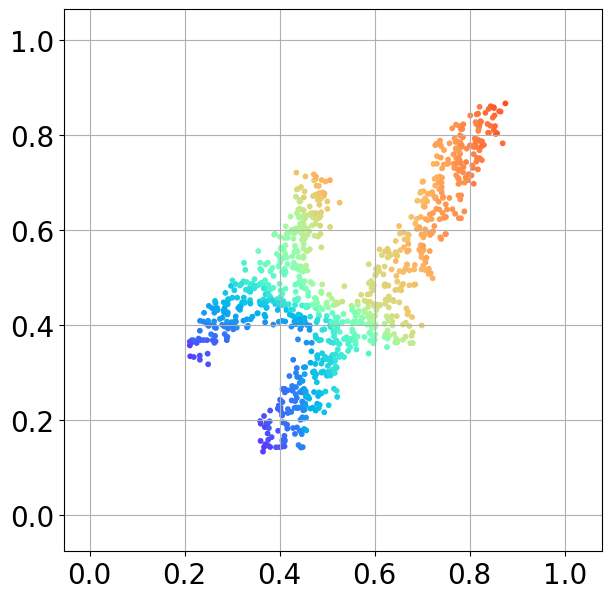

In [28]:
# Plot the barycentric projection
source_samples = torch.from_numpy(source_samples)
X_norm = torch.zeros_like(source_samples)
x_min, x_max = source_samples[:, 0].min(), source_samples[:, 0].max()
y_min, y_max = source_samples[:, 1].min(), source_samples[:, 1].max()
X_norm[:, 0] = (source_samples[:, 0] - x_min) / (x_max - x_min + 1e-8)
X_norm[:, 1] = (source_samples[:, 1] - y_min) / (y_max - y_min + 1e-8)

# Combine x and y into a single scalar for colormap mapping
color_weights = 0.5 * X_norm[:, 0] + 0.5 * X_norm[:, 1]  # weighted average
colors = rainbow(color_weights.cpu())

plt.figure(figsize=(6, 6))
plt.scatter(T_ot[:, 0], T_ot[:, 1], s=10, color=colors, label=f"t={t:.2f}")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(x_min.cpu()-0.25, x_max.cpu()+0.25)
plt.ylim(y_min.cpu()-0.25, y_max.cpu()+0.25)
plt.show()